In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fif as FIF
import matplotlib
import pandas as pd
from datetime import date
!pip install PyWavelets
import pywt
from scipy.signal import convolve2d
from sklearn import datasets
from sklearn import feature_selection
from sklearn import metrics
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc
!pip install statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import csv

import sklearn


#Importing various datasets

#dataset 1
df1 = pd.read_csv(r'C:\Users\George\Documents\Physics\Year 3\Part 2\Group Project\Data\data 1.csv',index_col=0)
df1=df1.replace(np.NaN,0)
df1['Date'] = pd.to_datetime(df1['Date'])
train1 = df1[(df1['Date'] < '2022-01-01')]
test1 = df1[(df1['Date'] > '2022-01-01')]

#dataset 2
df2 = pd.read_csv(r'C:\Users\George\Documents\Physics\Year 3\Part 2\Group Project\Data\data 2.csv',index_col=0)
df2['Date'] = pd.to_datetime(df2['Date'])
df2=df2.replace(np.NaN,0)
train2 = df2[(df2['Date'] < '2022-01-01')]
test2 = df2[(df2['Date'] > '2022-01-01')]


#autocorrelation values (Spot Only)
autocor = pd.read_csv(r'C:\Users\George\Documents\Physics\Year 3\Part 2\Group Project\Data\Autocorrelation lengths.csv')


#dataset 2 with true anoms
df4 = pd.read_csv(r'C:\Users\George\Documents\Physics\Year 3\Part 2\Group Project\Data\data 2 anoms.csv',index_col=0)
df4=df4.replace(np.NaN,0)
df4['Date'] = pd.to_datetime(df4['Date'])
train4 = df4[(df4['Date'] < '2022-01-01')]
test4 = df4[(df4['Date'] > '2022-01-01')]


#log returns of dataset 1
df5 = pd.read_csv(r'C:\Users\George\Documents\Physics\Year 3\Part 2\Group Project\Data\logreturns1.csv',index_col=0)
df5=df5.replace(0,np.NaN)
df5['Date'] = pd.to_datetime(df5['Date'])


#log returns of dataset 2
df6 = pd.read_csv(r'C:\Users\George\Documents\Physics\Year 3\Part 2\Group Project\Data\logreturns2.csv',index_col=0)
df6=df6.replace(np.NaN,0)
df6['Date'] = pd.to_datetime(df6['Date'])

#log returns of dataset 2 with true anoms
df7 = pd.read_csv(r'C:\Users\George\Documents\Physics\Year 3\Part 2\Group Project\Data\logreturns2 anoms.csv',index_col=0)
df7=df7.replace(np.NaN,0)
df7['Date'] = pd.to_datetime(df7['Date'])

#replacing any missing values with 0 in the log return files. this can be changed to any value
df7=df7.replace('#NUM!',0)
df6=df6.replace('#NUM!',0)
df7=df7.replace('#DIV/0!',0)
df6=df6.replace('#DIV/0',0)


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\George\AppData\Local\Temp\ipykernel_13264\4078342116.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['Date'] = pd.to_datetime(df1['Date'])
C:\Users\George\AppData\Local\Temp\ipykernel_13264\4078342116.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['Date'] = pd.to_datetime(df2['Date'])
C:\Users\George\AppData\Local\Temp\ipykernel_13264\4078342116.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df4['Date'] = pd.to_datetime(

In [2]:
#This first class is extracted from Benjamin's autocorrelation value function 
class log_returns_class():
    def __init__(self, currencyOfInterest, Rate, log_gap, ):
        df = pd.read_csv(r'C:\Users\George\Documents\Physics\Year 3\Part 2\Group Project\Data\data 2.csv',index_col=0)
        dataOI = df[df['Currency']==currencyOfInterest]
        dates = pd.to_datetime(dataOI['Date'])
        spotRates = dataOI[Rate]
        self.log_returns = np.log(spotRates.shift(log_gap)/spotRates)
        self.dates_log = dates.shift(log_gap)
        self.log_gap = log_gap
        self.spotRates = spotRates
        
        
    def autocorl_length(self):
        acf,confidence_interval=sm.tsa.acf(self.spotRates,nlags=len(self.spotRates), alpha=0.05,fft=False)
        lower_bound = confidence_interval[1:, 0] - acf[1:]
        for i in range(len(acf)):
            if (-lower_bound[i])>acf[i]:
                self.AUTO_length = i
                break
        return self.AUTO_length

#This returns the autocorl length of the data returns as "self.AUTO_length"



#This class contains functions to set paramters, use wavelet transforms, run the FIF and the IF Selection method, as well as run an ROC test
#ac should be the autocorl length from the previous class
#I am using dataset 2 for both train and test, since for the FIF you do not actually use a training dataset.
class waveletsplit:
    def __init__(self, train, test, currency, ac):
        self.train = train
        self.test = test
        self.currency = currency
        self.ratetitle = ['Date', 'Spot Rate', '1W Rate', '2W Rate', '3W Rate', '1M Rate', '2M Rate', '3M Rate', '4M Rate', '6M Rate', '9M Rate', '1Y Rate', '2Y Rate', '3Y Rate', '4Y Rate', '5Y Rate', '10Y Rate']
        #self.window = ac.loc[ac['Currency'] == self.currency, 'Autocorrelation length'].iloc[0]
        self.window=ac
        
    #Seperating the desired currency
    def currencyset(self):
        self.ctrain= self.train.loc[self.train['Currency'] == str(self.currency)]
        self.ctrain=self.ctrain.drop(labels=['Currency'], axis=1)
    
        self.ctest= self.test.loc[self.test['Currency'] == str(self.currency)]
        self.ctest=self.ctest.drop(labels=['Currency'], axis=1)
        return self.ctrain,self.ctest
    
    #turns the pandas dataframe to an array
    def currencytoarray(self):
        self.atrain=self.ctrain[self.ratetitle].to_numpy(na_value=0)
        self.atrain=np.transpose(self.atrain)
    
        self.atest=self.ctest[self.ratetitle].to_numpy(na_value=0)
        self.atest=np.transpose(self.atest)
    
        for i in range(0,len(self.atrain[0])):
            self.atrain[0,i]=self.atrain[0,i].timestamp()
        for i in range(0,len(self.atest[0])):
            self.atest[0,i]=self.atest[0,i].timestamp()
        
        self.atrain=np.float64(self.atrain)
        self.atest=np.float64(self.atest)        
        return self.atrain,self.atest
        
    #Choose the rate you want to use in the FIF (e.g. 'Spot Rate')
    def arraytorate(self,rate):
        a=self.ratetitle.index(str(rate))
        self.ratetrain=self.atrain[a]
        self.ratetest=self.atest[a]
        return self.ratetrain,self.ratetest
        
    #turn the rate of a currency into a window 
    def towindows(self,overlap):
        self.trainwindows=[]
        self.testwindows=[]
        self.overlap=overlap
        for i in range(0,len(self.ratetrain)-self.window,overlap):
            wind=self.ratetrain[i:i+self.window]
            self.trainwindows.append(wind)
            
        for i in range(0,len(self.ratetest)-self.window,overlap):
            wind=self.ratetest[i:i+self.window]
            self.testwindows.append(wind)
            return self.trainwindows,self.testwindows
        
    #turn each window into a wavelet USING VARIANCE METHOD
    def wintowaveletvar(self,wavelet,scale1,scale2):
        self.wavelet=wavelet
        scales = np.arange(scale1, scale2)
        self.traincoeffs=[]
        self.testcoeffs=[]
        bs1=[]
        for i in range(0,len(self.trainwindows)):
            coefficients, frequencies = pywt.cwt(self.trainwindows[i], scales, self.wavelet)
            #choosing scale based on which provides most variance between coefficients
            variances = np.var(coefficients, axis=1)
            best_scale = np.argmax(variances)
            bs1.append(best_scale)
            self.traincoeffs.append(coefficients[best_scale])
        
            
        for i in range(0,len(self.testwindows)):
            self.coefficients, self.frequencies = pywt.cwt(self.testwindows[i], scales, self.wavelet)
            #choosing scale based on which provides most variance between coefficients
            variances = np.var(coefficients, axis=1)
            best_scale = np.argmax(variances)
            self.testcoeffs.append(coefficients[best_scale])
            
        return self.traincoeffs,self.testcoeffs,bs1
    
    #OR turn each window into a wavelet USING MEAN METHOD
    def wintowaveletmean(self,wavelet,scale1,scale2):
        self.wavelet=wavelet
        scales = np.arange(scale1, scale2)
        self.traincoeffs=[]
        self.testcoeffs=[]
        bs2=[]
        mean=[]
        for i in range(0,len(self.trainwindows)):
            coefficients, frequencies = pywt.cwt(self.trainwindows[i], scales, self.wavelet)
            #choosing scale based on which provides largest mean
            for s in range(0,coefficients.shape[0]):
                mean.append(np.mean(coefficients[s], axis=0))
            best_scale =np.argmax(np.abs(mean))
            bs2.append(best_scale)
            mean=[]
            self.traincoeffs.append(coefficients[best_scale])
            
            
        for i in range(0,len(self.testwindows)):
            self.coefficients, self.frequencies = pywt.cwt(self.testwindows[i], scales, self.wavelet)
            #choosing scale based on which provides largest mean
            for s in range(0,coefficients.shape[0]):
                mean.append(np.mean(coefficients[s], axis=0))
            best_scale =np.argmax(np.abs(mean))
            bs2.append(best_scale)
            mean=[]
            self.testcoeffs.append(coefficients[best_scale])
            
        return self.traincoeffs,self.testcoeffs,bs2
    
    #reconstructing the data from the wavelet
    def waveletreco(self):
        self.trainreco = pywt.waverec([self.traincoeffs], self.wavelet)
        self.testreco = pywt.waverec([self.testcoeffs], self.wavelet)

        return self.trainreco,self.testreco

    #running the FIF on the data provided
    def FuncIF(self, data, dic):
        data2=data
        a=list(range(0,len(data[0])))
        data2.insert(0,a)
        data2=np.float64(data2)
            #data[0] should be the timeframe of the dataset
        F = FIF.FiForest(data2, data2[0],  sample_size=self.window, alpha=0.5, dic_number=dic)
            # dic_number set the dictionary where data are projected.three dictionaries are available:
            # 0 corresponds to Brownian motion, 1 to gaussian wavelets and 2 to cosine dictionary.
        S1 = F.compute_paths()
        return S1
            


    #This is the IF Selection method to find an anomalous point within a given anomalous window
    #data2 should be the results from the FIF
    #I am using the log returns of dataset 1 to train the IF, and the log returns of dataset 2 for testing. I perform a currency set
    #and a few other details later in the code
    def findanoms(self, data2, contam, training, testing, anomaly_inputs):
        windowanom=[]
        scores=pd.DataFrame(data=data2,columns=['AnomalyScore'])
        scores=scores.sort_values(by='AnomalyScore',ascending=False)
        anoms = scores['AnomalyScore'].nlargest(int(len(scores['AnomalyScore']) * contam))
        model = IsolationForest(contamination=0.02, random_state=42)
        model.fit(training[anomaly_inputs])
        for i in range(0,len(anoms.index)):
            testpoints=testing[anoms.index[i]:anoms.index[i]+self.window]
            
            #switch to these if want to randomise the window for IF Selection
            #testpointsrand=testpoints.sample(frac=1, random_state=42)
            #pointanom=model.decision_function(testpointsrand[anomaly_inputs])
            
            
            pointanom=model.decision_function(testpoints[anomaly_inputs])
            pointanom=pd.DataFrame(pointanom,columns = ['Anomalyscore'])
            pointanom.index.name='id'
            pointanom=pointanom.sort_values(by='Anomalyscore',ascending=True)
            point=pointanom.iloc[0].name+anoms.index[i]
            
            #this loop ensures we do not get duplicate values returned as anomalies
            j=0
            while j < len(pointanom):
                point = pointanom.iloc[j].name + anoms.index[i]
                if point not in windowanom:
                    windowanom.append(point)
                    break
                j += 1
            
            
        return windowanom
    
    #This completes and ROC evaluation of the method
    def rocauc(self,trues):
        tot = self.ctest.shape[0]
        contam = []
        TPR = []
        FPR = []
        trupos=[]
    
        for i in np.arange(0, 1, 0.01):
            #The variables in this findanoms function should be altered as needed
            anoms=self.findanoms(reco1, i,c3,c4,['Spot Rate', '1W Rate', '2W Rate', '3W Rate', '1M Rate', '2M Rate', '3M Rate', '4M Rate', '6M Rate', '9M Rate', '1Y Rate', '2Y Rate', '3Y Rate', '4Y Rate', '5Y Rate', '10Y Rate'])
            anoms=list(set(anoms))
            anoms = pd.DataFrame(index=anoms)

        
            # Calculate TP, FP, FN, TN
            TP = (anoms.merge(trues,left_index=True, right_index=True)).shape[0]
            FP = len(anoms) - TP
            FN = len(trues) - TP
            TN = tot - TP - FP - FN
            ol=TP/(TP+FN)*100
            trupos.append(ol)
        
            print('TP:',TP)
            print('FP:',FP)
            print('FN:',FN)
            print('TN:',TN)
        
            # Calculate TPR and FPR
            if TP + FN != 0:
                tpr = TP / (TP + FN)
            else:
                tpr = 0
            if FP + TN != 0:
                fpr = FP / (FP + TN)
            else:
                fpr = 0
        
            # Append to lists
            contam.append(i)
            TPR.append(tpr)
            FPR.append(fpr)
        
        
        return contam, TPR, FPR, trupos
    
    
    


#Setting the currency and spot rate desired for the autocorrelation function
currencyOfInterest = 'GBP'
Rate = "5Y Rate"

log_gap = 1
LOG_RET = log_returns_class(currencyOfInterest, Rate, log_gap)

#ac is the autocorrelation value desired
ac=LOG_RET.autocorl_length()
print(ac)

#initialising the class to run the FIF using dataset 2 
wavelet1=waveletsplit(df2,df2,'GBP',ac)
#simply setting the currency 
c1,c2=wavelet1.currencyset()
#turning the dataframe to an array
wavelet1.currencytoarray()
#setting the desired tenor
wavelet1.arraytorate('5Y Rate')
#changing the dataset into windows, with an overlap of 1
wavelet1.towindows(1)
#completing a wavelet transform, with a variance scale selection. I have selected to only view scales between 1 and 190, 
#as I have found this to be sufficient for capturing all important data
GBPtrain1coeff,GBPtest1coeff,bs=wavelet1.wintowaveletvar('gaus5',1,190)

#this next line can be used instead of the previous line, if want to use the mean scale selection method
#GBPtrain1coeff,GBPtest1coeff,bs=wavelet1.wintowaveletmean('gaus5',1,190)

#Reconstructing the values from the wavelet transform
GBPtrain1reco,GBPtest1reco=wavelet1.waveletreco()

#Either of these lines can be used depending on if you wish to use the FIF with the wavelet coefficients, or the reconstructed values
#The number represents the dictionary:
#0 = Brownian Motion, 1 = Gaussian Wavelet, 2 = Cosine

#coeff1=wavelet1.FuncIF(GBPtrain1coeff,0)
reco1=wavelet1.FuncIF(GBPtrain1reco,0)

C:\Users\George\AppData\Local\Temp\ipykernel_13264\3564947319.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates = pd.to_datetime(dataOI['Date'])


103


In [3]:
#Initialising the log return datasets to use in the IF Selection Method
wavelet2=waveletsplit(df5,df7,'GBP',ac)
c3,c4=wavelet2.currencyset()

#replacing any NaNs with 0, can be set to any number
c3=c3.replace(np.NaN,0)
c4=c4.replace(np.NaN,0)
c4=c4.replace('#NUM!',0)
c3=c3.replace('#NUM!',0)
c4=c4.replace('#DIV/0!',0)
c3=c3.replace('#DIV/0!',0)

#this nect line is sufficient if you wish to find the final anomaly values of a certain contamination level. Remember to swap
#reco1 for coeff1 if you wish to use the FIF on the wavelet coefficients. 
#The tenors can also be changed for the IF selection method by altering the array below
a=wavelet2.findanoms(reco1,0.1,c3,c4,['Spot Rate', '1W Rate', '2W Rate', '3W Rate', '1M Rate', '2M Rate', '3M Rate', '4M Rate', '6M Rate', '9M Rate', '1Y Rate', '2Y Rate', '3Y Rate', '4Y Rate', '5Y Rate', '10Y Rate'])


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [9]:
#determining the true anomalies given in the dataset
true= df4.loc[df4['Currency'] == 'GBP']
true=true.loc[true['Anomaly'] == 1]


In [5]:
#Viewing the anomalies returned by the FIF and IF selection method

df = pd.DataFrame({'Value': a})
counts = df['Value'].value_counts().reset_index()
counts.columns = ['Value', 'Count']

counts

,Value,Count
0,4,1
1,1768,1
2,887,1
3,868,1
4,891,1
...,...,...
165,892,1
166,899,1
167,621,1
168,910,1


In [12]:
#seeing how many anomalies the FIF returns are true positives
truepositives=df.merge(true,left_on='Value',right_index=True)
truepositives

,Value,Anomaly,Date,SourceID,Currency,Spot Rate,1W Rate,2W Rate,3W Rate,1M Rate,...,3M Rate,4M Rate,6M Rate,9M Rate,1Y Rate,2Y Rate,3Y Rate,4Y Rate,5Y Rate,10Y Rate
0,4,1,2017-07-31,13311453,GBP,1.38430,1.38447,1.38454,1.38475,1.38508,...,1.38664,1.38727,1.38901,1.39115,1.39382,1.40429,1.41541,1.42708,1.43864,1.49244
8,1712,1,2022-09-25,13311453,GBP,1.16693,1.16730,1.16714,1.16729,1.16745,...,1.16819,1.16865,1.16911,1.16954,1.17048,1.16942,1.17023,1.17345,1.17938,1.22580
21,885,1,2020-05-19,13311453,GBP,1.22264,1.22273,1.22304,1.22322,1.22335,...,1.22515,1.22558,1.22702,1.22863,1.23011,1.23566,1.24093,1.24735,1.25414,1.30039
35,890,1,2020-05-25,13311453,GBP,1.24880,1.24891,1.24920,1.24954,1.24961,...,1.25106,1.25172,1.25286,1.25470,1.25639,1.26262,1.26875,1.27533,1.28257,1.32754
83,1692,1,2022-09-05,13311453,GBP,1.21229,1.21251,1.21226,1.21233,1.15111,...,1.21315,1.21403,1.21450,1.21526,1.21579,1.21790,1.22236,1.22799,1.23548,1.27483
111,1691,1,2022-09-04,13311453,GBP,1.21718,1.21712,1.21703,1.21716,1.21728,...,1.21786,1.21872,1.21926,1.22007,1.22064,1.22245,1.22699,1.23321,1.23998,1.27455


In [13]:
 #Running the ROC evaluation for the FIF and IF Selection Method
cont,tpr,fpr,olap=wavelet1.rocauc(true)

C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 0
FP: 0
FN: 31
TN: 1779


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 2
FP: 15
FN: 29
TN: 1764


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 3
FP: 31
FN: 28
TN: 1748


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 4
FP: 47
FN: 27
TN: 1732


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 4
FP: 64
FN: 27
TN: 1715


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 5
FP: 80
FN: 26
TN: 1699


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 5
FP: 97
FN: 26
TN: 1682


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 6
FP: 113
FN: 25
TN: 1666


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 6
FP: 130
FN: 25
TN: 1649


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 6
FP: 147
FN: 25
TN: 1632


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 6
FP: 164
FN: 25
TN: 1615


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 9
FP: 178
FN: 22
TN: 1601


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 11
FP: 193
FN: 20
TN: 1586


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 20
FP: 202
FN: 11
TN: 1577


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 20
FP: 219
FN: 11
TN: 1560


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 20
FP: 236
FN: 11
TN: 1543


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 20
FP: 253
FN: 11
TN: 1526


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 21
FP: 269
FN: 10
TN: 1510


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 21
FP: 286
FN: 10
TN: 1493


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 21
FP: 303
FN: 10
TN: 1476


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 21
FP: 320
FN: 10
TN: 1459


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 23
FP: 335
FN: 8
TN: 1444


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 23
FP: 352
FN: 8
TN: 1427


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 23
FP: 369
FN: 8
TN: 1410


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 23
FP: 386
FN: 8
TN: 1393


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 23
FP: 404
FN: 8
TN: 1375


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 23
FP: 421
FN: 8
TN: 1358


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 23
FP: 438
FN: 8
TN: 1341


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 23
FP: 455
FN: 8
TN: 1324


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 23
FP: 472
FN: 8
TN: 1307


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 23
FP: 489
FN: 8
TN: 1290


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 26
FP: 503
FN: 5
TN: 1276


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 518
FN: 3
TN: 1261


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 535
FN: 3
TN: 1244


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 552
FN: 3
TN: 1227


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 569
FN: 3
TN: 1210


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 586
FN: 3
TN: 1193


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 603
FN: 3
TN: 1176


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 621
FN: 3
TN: 1158


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 638
FN: 3
TN: 1141


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 655
FN: 3
TN: 1124


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 672
FN: 3
TN: 1107


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 689
FN: 3
TN: 1090


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 706
FN: 3
TN: 1073


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 723
FN: 3
TN: 1056


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 740
FN: 3
TN: 1039


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 28
FP: 757
FN: 3
TN: 1022


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 29
FP: 773
FN: 2
TN: 1006


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 29
FP: 790
FN: 2
TN: 989


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 806
FN: 1
TN: 973


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 824
FN: 1
TN: 955


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 841
FN: 1
TN: 938


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 858
FN: 1
TN: 921


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 875
FN: 1
TN: 904


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 892
FN: 1
TN: 887


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 909
FN: 1
TN: 870


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 926
FN: 1
TN: 853


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 943
FN: 1
TN: 836


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 960
FN: 1
TN: 819


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 977
FN: 1
TN: 802


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 994
FN: 1
TN: 785


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1011
FN: 1
TN: 768


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1028
FN: 1
TN: 751


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1046
FN: 1
TN: 733


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1063
FN: 1
TN: 716


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1080
FN: 1
TN: 699


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1097
FN: 1
TN: 682


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1114
FN: 1
TN: 665


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1131
FN: 1
TN: 648


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1148
FN: 1
TN: 631


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1165
FN: 1
TN: 614


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1182
FN: 1
TN: 597


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1199
FN: 1
TN: 580


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1216
FN: 1
TN: 563


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1233
FN: 1
TN: 546


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1251
FN: 1
TN: 528


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1268
FN: 1
TN: 511


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1285
FN: 1
TN: 494


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1302
FN: 1
TN: 477


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1319
FN: 1
TN: 460


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1336
FN: 1
TN: 443


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1353
FN: 1
TN: 426


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1370
FN: 1
TN: 409


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1387
FN: 1
TN: 392


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1404
FN: 1
TN: 375


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1421
FN: 1
TN: 358


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1438
FN: 1
TN: 341


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1455
FN: 1
TN: 324


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1473
FN: 1
TN: 306


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1490
FN: 1
TN: 289


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1505
FN: 1
TN: 274


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1521
FN: 1
TN: 258


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1537
FN: 1
TN: 242


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1551
FN: 1
TN: 228


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1562
FN: 1
TN: 217


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1576
FN: 1
TN: 203


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1582
FN: 1
TN: 197


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1586
FN: 1
TN: 193


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1587
FN: 1
TN: 192


C:\Users\George\PycharmProjects\GITFIF\venv\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


TP: 30
FP: 1588
FN: 1
TN: 191


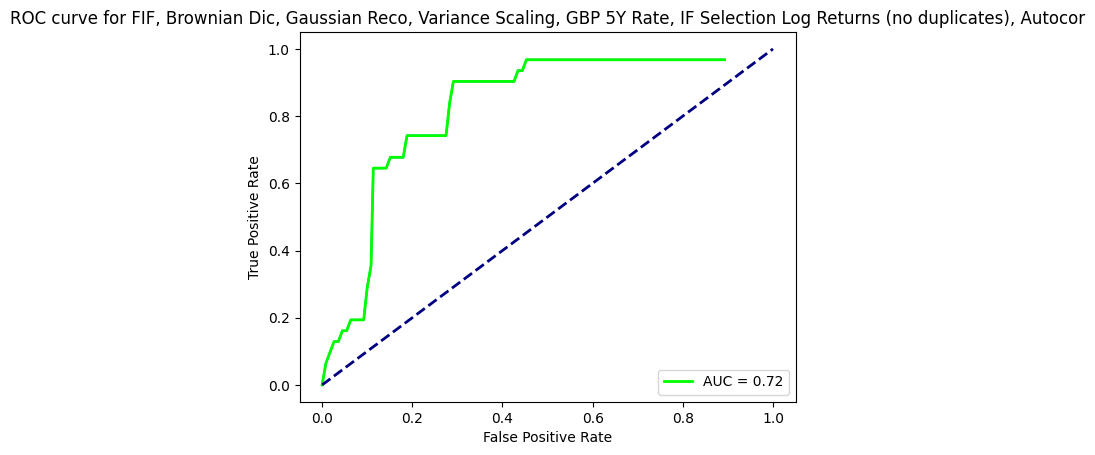

0.7205298373497253


In [14]:
#Plotting the ROC and AUC value
a=auc(fpr,tpr)
plt.plot(fpr,tpr)
plt.title('ROC curve for FIF, Brownian Dic, Gaussian Reco, Variance Scaling, GBP 5Y Rate, IF Selection Log Returns (no duplicates), Autocor')
plt.plot(fpr, tpr, color='lime', lw=2, label=f'AUC = {a:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
print(auc(fpr,tpr))

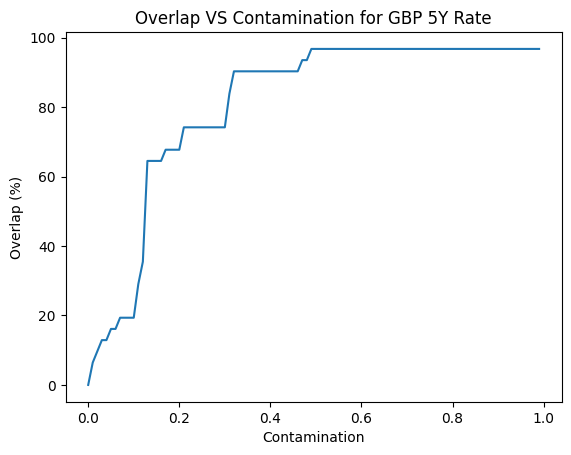

In [15]:
#plotting contamination vs overlap
plt.plot(cont, olap)
plt.title('Overlap VS Contamination for GBP 5Y Rate')
plt.xlabel('Contamination')
plt.ylabel('Overlap (%)')
plt.show()